# Compute files for cloud plots for models

In [1]:
%load_ext autoreload
%autoreload 2


import useful_scit.util.log as log
import numpy as np
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel, rn_dic_ec_earth_cloud
from datetime import timedelta

In [2]:

import xarray as xr

import matplotlib.pyplot as plt
from bs_fdbck.constants import path_extract_latlon_outdata

from bs_fdbck.util.imports import import_fields_xr_echam

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud, \
    rn_dic_noresm_cloud

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

import pandas as pd

from timeit import default_timer as timer

from dask.diagnostics import ProgressBar

from bs_fdbck.util.BSOA_datamanip.atto import season2month

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv


In [3]:
from bs_fdbck.constants import path_measurement_data

In [4]:
xr.set_options(keep_attrs=True)
log.ger.setLevel(log.log.INFO)

## General settings

In [5]:

select_station = 'ATTO'

calc_seasons = ['ALL_year']

tau_lims = [5, 50]
r_eff_lim = 1
cloud_top_temp_above = -15
cld_water_path_above = 50

postproc_data = path_measurement_data / 'model_station' / select_station
postproc_data_obs = path_measurement_data / select_station / 'processed'

In [6]:
lon_lims = [293., 308.]
lat_lims = [-8., -1.]

lat_station = -2.150
lon_station = 360 - 59.009
model_lev_i = -1

temperature = 273.15  # K

from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 = '2015-01-01'
to_time2 = '2019-01-01'
sel_years_from_files = ['2012', '2014', '2015', '2018']

In [7]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f' % (*lon_lims,)
str_latlim = '%.1f-%.1f' % (*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'

#### Daytime values


Set the daytime to be from 10 to 17 each day

In [8]:
daytime_from = 9
daytime_to = daytime_from + 7

## Read in model station data:

In [9]:
models = ['ECHAM-SALSA', 'NorESM', 'EC-Earth']
mod2cases = {'ECHAM-SALSA': ['SALSA_BSOA_feedback'],
             'NorESM': ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth': ['ECE3_output_Sara'],
             }
di_mod2cases = mod2cases.copy()

In [10]:
dic_df_pre=dict()
for mod in models:
    print(mod)
    dic_df_pre[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        if model_lev_i !=-2:
            fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}_ilev{model_lev_i}.csv'
        else:
            fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'

        #fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_pre[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_pre[mod][ca].index = pd.to_datetime(dic_df_pre[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback_ilev-1.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp_ilev-1.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_EC-Earth_ECE3_output_Sara_ilev-1.csv


In [11]:
dic_df_station = dict()
for mod in models:
    print(mod)
    dic_df_station[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        if model_lev_i !=-2:
            fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}_ilev{model_lev_i}.csv'
        else:
            fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        
        print(fn_out)
        dic_df_station[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_station[mod][ca].index = pd.to_datetime(dic_df_station[mod][ca].index)
        # dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback_ilev-1.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp_ilev-1.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_EC-Earth_ECE3_output_Sara_ilev-1.csv


## Calculate datasets for each model

### NorESM

In [12]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

case_name1 = 'OsloAero_intBVOC_f09_f09_mg17_full'
case_name2 = 'OsloAero_intBVOC_f09_f09_mg17_ssp245'

In [13]:
cases = [case_name]

#### Path input data

In [14]:
path_input_data_noresm = path_extract_latlon_outdata / case_name

#### Filenames to store products in 3d/2d

In [15]:
# Filename for case1 concatinated over time 
fn1 = path_extract_latlon_outdata / case_name1 / f'{case_name1}.h1._{from_time1}-{to_time1}_concat_subs_{str_coordlims}.nc'

# Select variables and time: 
fn1_2 = fn1.parent / f'{fn1.stem}_sort.nc'
# Sortby time: 
fn1_3 = fn1.parent / f'{fn1.stem}_sort3.nc'

# Filename for case1 concatinated over time 

fn2 = path_extract_latlon_outdata / case_name2 / f'{case_name2}.h1._{from_time2}-{to_time2}_concat_subs_{str_coordlims}.nc'

# Select variables and time: 
fn2_2 = fn2.parent / f'{fn2.stem}_sort.nc'
# Sortby time: 
fn2_3 = fn2.parent / f'{fn2.stem}_sort3.nc'

# Concatinated case1 and case2 
fn_comb = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
# Concatinated only 

# fn_comb_lev1           = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1.nc'
fn_comb_lev1_final = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_comb_lev1_finaler = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finaler.nc'
fn_comb_lev1_final_csv = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final_wet_season.csv'
fn_final_csv_stem = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.csv'

In [16]:
print(fn_comb_lev1_final_csv)

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_final_wet_season.csv


#### Define NorESM station variables and cloud variables

In [17]:
varl_st = ['SOA_NA', 'SOA_A1', 'OM_NI', 'OM_AI', 'OM_AC', 'SO4_NA', 'SO4_A1', 'SO4_A2', 'SO4_AC', 'SO4_PR',
           'BC_N', 'BC_AX', 'BC_NI', 'BC_A', 'BC_AI', 'BC_AC', 'SS_A1', 'SS_A2', 'SS_A3', 'DST_A2', 'DST_A3',
           'N50', 'N100', 'N150', 'N200', 'N500',
           #           'N50-500','N100-500', 'N150-500', 'N200-500',
           # 'OA',
           ]
varl_st_computed = ['OA', 'OA_STP', 'OA_amb', 'T_C',  
                    'N50_STP', 'N100_STP', 'N150_STP', 'N200_STP', 'N500_STP',
                    'N50-500_STP', 'N100-500_STP', 'N150-500_STP', 
                    'N200-500_STP', 'N500_STP',
                   ]

varl_cl = ['TOT_CLD_VISTAU', 'TOT_ICLD_VISTAU', 'TGCLDCWP', 'TGCLDLWP', 'TGCLDIWP',
           'TOT_CLD_VISTAU_s', 'TOT_ICLD_VISTAU_s', 'optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL', 'ACTNL', 'TGCLDLWP',
           'FSDSC', 'FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC', 'FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

#### Concatinate files, compute 2D fields from 3D fields (compute tau) and sortby time.

In [18]:
fn_comb.exists()

True

In [19]:
if not fn_comb.exists():
    if (not fn1_2.exists()) or (not fn2_2.exists()):
        ds_mod1 = xr.open_dataset(fn1, chunks={'time': 96}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod2 = xr.open_dataset(fn2, chunks={'time': 96}, engine='netcdf4')

        varl1 = set(ds_mod1.data_vars)

        varl2 = set(ds_mod2.data_vars)

        varl = list(varl1.intersection(varl2))

        ds_mod1 = ds_mod1[varl].sel(time=slice(sel_years_from_files[0], sel_years_from_files[1]))  # .sortby('time')

        ds_mod2 = ds_mod2[varl].sel(time=slice(sel_years_from_files[2], sel_years_from_files[3]))  # .sortby('time')
        if not fn1_2.exists():
            delayed_obj = ds_mod1.to_netcdf(fn1_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
        if not fn2_2.exists():
            delayed_obj = ds_mod2.to_netcdf(fn2_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()

    if not fn1_3.exists():
        ds_mod1 = xr.open_dataset(fn1_2, chunks={'time': 48}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod1 = compute_total_tau(ds_mod1)
        ds_mod1 = ds_mod1.isel(lev=model_lev_i)
        ds_mod1 = ds_mod1.sortby('time')  # .sel(time=slice('2012','2014'))
        delayed_obj = ds_mod1.to_netcdf(fn1_3, compute=False)
        print('hey 1')
        with ProgressBar():
            results = delayed_obj.compute()
    if not fn2_3.exists():
        ds_mod2 = xr.open_dataset(fn2_2, chunks={'time': 48}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod2 = compute_total_tau(ds_mod2)
        ds_mod2 = ds_mod2.isel(lev=model_lev_i)
        ds_mod2 = ds_mod2.sortby('time')  # .sel(time=slice('2012','2014'))
        delayed_obj = ds_mod2.to_netcdf(fn2_3, compute=False)
        print('hey')
        with ProgressBar():
            results = delayed_obj.compute()

    ds_mod = xr.open_mfdataset([fn1_3, fn2_3], combine='by_coords', concat_dim='time')

    fn_comb.parent.mkdir(exist_ok=True, )

    delayed_obj = ds_mod.to_netcdf(fn_comb, compute=False)
    with ProgressBar():
        results = delayed_obj.compute()

    # ds_mod = xr.concat([ds_mod1[varl].sel(time=slice('2012','2014')), ds_mod2[varl].sel(time=slice('2015','2018'))], dim='time')

In [20]:
fn1_3.exists()

False

In [21]:
fn2_3.exists()

True

In [22]:
fn_comb

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc')

##### Check: 

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


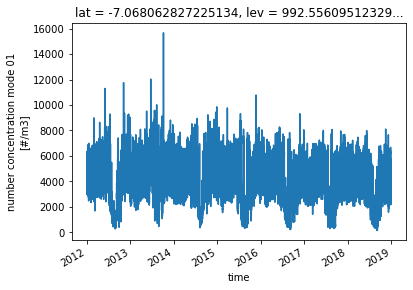

In [23]:
ds_mod = xr.open_dataset(fn_comb, engine='netcdf4', chunks={'time': 48})
(1e-6 * ds_mod['NCONC01'].isel(lat=0, lon=0)).plot()

#### Change units and compute variables

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [24]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb, engine='netcdf4').isel(ilev=model_lev_i)
    # ds_sel = ds_all.sel(lat = lat_station, lon= lon_station, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
        nbnd=0
    ).squeeze()
    # ds_all = broadcase_station_data(ds_all, lon = lon_station, lat = lat_station)
    ds_all = change_units_and_compute_vars(ds_all, temperature=temperature)

    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()


#### Add variables from station data to imitate using station measurements

In [25]:
df_comb_station = dic_df_station['NorESM']['OsloAero_intBVOC_f09_f09_mg17_fssp']
df_comb_station.head()

,station,ACTREL,lev,BC_A,BC_AC,BC_AI,BC_AX,BC_N,BC_NI,COAGNUCL,...,year,density,ambient2stp_correction_factor,N100_STP,N200_STP,N50_STP,N500_STP,N50-500_STP,N100-500_STP,N200-500_STP
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 20:00:00,ATTO,0.0,992.556095,9.760506e-12,1.927384e-12,5.984160e-12,1.493344e-13,9.143349e-13,2.501827e-15,0.000015,...,2012,1.170136,1.104357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 21:00:00,ATTO,0.0,992.556095,1.173306e-11,1.929752e-12,6.213474e-12,1.896768e-13,1.132375e-12,2.577372e-15,0.000016,...,2012,1.171287,1.103271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 22:00:00,ATTO,0.0,992.556095,1.415127e-11,1.925523e-12,6.477718e-12,2.003883e-13,1.141799e-12,2.292829e-15,0.000016,...,2012,1.172208,1.102405,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 23:00:00,ATTO,0.0,992.556095,1.652237e-11,1.922480e-12,6.741639e-12,1.983007e-13,1.098991e-12,2.073961e-15,0.000017,...,2012,1.172795,1.101852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02 00:00:00,ATTO,0.0,992.556095,1.885198e-11,1.922657e-12,7.010868e-12,1.940676e-13,1.057980e-12,1.893479e-15,0.000018,...,2012,1.173101,1.101565,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Open dataset computed above

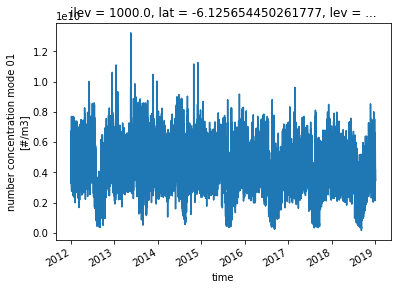

In [26]:

ds_all = xr.open_dataset(fn_comb_lev1_final, chunks={'lon': 1}, engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['NCONC01'].isel(lat=1, lon=1).plot()

#### *Mask if ice water path more than 5% of total water path

In [27]:
mask_liq_cloudtop = (ds_all['FCTL']>0.05) & (ds_all['FCTL']/(ds_all['FCTL']+ds_all['FCTI'])>.8)

mask_liq_cloudtop
ds_all['mask_liq_cloudtop'] = mask_liq_cloudtop
#ds_all = ds_all.where(mask_liq_cloudtop)

In [28]:
ds_all['frac_lwp2cwp'] = ds_all['TGCLDLWP']/(ds_all['TGCLDIWP']+ds_all['TGCLDLWP'])
ds_all['mask_by_lwp2cwp'] = ds_all['frac_lwp2cwp']>0.95

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


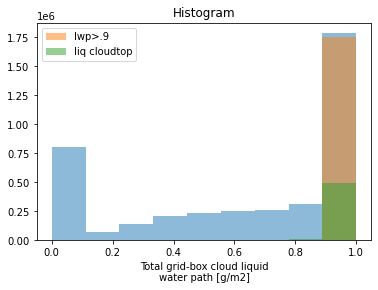

In [29]:
ds_all['frac_lwp2cwp'].plot.hist(alpha=0.5,bins=np.linspace(0,1,10))

ds_all['frac_lwp2cwp'].where(ds_all['frac_lwp2cwp']>0.9).plot.hist(alpha=0.5, bins=np.linspace(0,1,10),label='lwp>.9')
ds_all['frac_lwp2cwp'].where(ds_all['mask_liq_cloudtop']).plot.hist(alpha=0.5, bins=np.linspace(0,1,10), label='liq cloudtop')

plt.legend()

In [30]:
ds_all= ds_all.where(ds_all['mask_by_lwp2cwp'])

#### * Mask if cloud top fraction of liquid is below 10 %

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(array([ 29337.,  19610.,  19400.,  16425.,  29244.,  14261.,  17469.,
         16205.,  19445., 165845.]),
 array([0.10000036, 0.19000033, 0.2800003 , 0.37000024, 0.46000022,
        0.5500002 , 0.64000016, 0.7300001 , 0.82000005, 0.91      ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

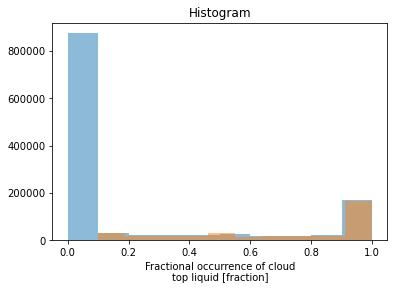

In [31]:
ds_all['FCTL'].where(ds_all['TGCLDCWP_incld']>50).plot(alpha=.5)
ds_all.where(ds_all['FCTL']>.1)['FCTL'].where(ds_all['TGCLDCWP_incld']>50).plot(alpha=.5)

In [32]:
ds_all = ds_all.where(ds_all['FCTL']>.1)

#### Shift timezone

In [33]:

with ProgressBar():
    ds_all.load()

if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=4)
    ds_all['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    # dic_ds[k] = _ds

[##################                      ] | 46% Completed |  1min  0.3s

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  1min  3.3s
shifted time by -4


#### Broadcast computed variables so that only station value is in the gridcells. 

In [34]:
ds_smll = ds_all[['NCONC01']]

In [35]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

In [36]:
varl_tmp = varl_st + varl_st_computed

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [37]:
varl_tmp = varl_st + varl_st_computed
set(df_comb_station.columns).intersection(set(varl_tmp))

{'BC_A',
 'BC_AC',
 'BC_AI',
 'BC_AX',
 'BC_N',
 'BC_NI',
 'DST_A2',
 'DST_A3',
 'N100-500_STP',
 'N100_STP',
 'N150',
 'N200-500_STP',
 'N200_STP',
 'N50-500_STP',
 'N500_STP',
 'N50_STP',
 'OA_STP',
 'OM_AC',
 'OM_AI',
 'OM_NI',
 'SO4_A1',
 'SO4_A2',
 'SO4_AC',
 'SO4_NA',
 'SO4_PR',
 'SOA_A1',
 'SOA_NA',
 'SS_A1',
 'SS_A2',
 'SS_A3',
 'T_C'}

In [38]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

SOA_NA
replacing SOA_NA 
SOA_A1
replacing SOA_A1 
OM_NI
replacing OM_NI 
OM_AI
replacing OM_AI 
OM_AC
replacing OM_AC 
SO4_NA
replacing SO4_NA 
SO4_A1
replacing SO4_A1 
SO4_A2
replacing SO4_A2 
SO4_AC
replacing SO4_AC 
SO4_PR
replacing SO4_PR 
BC_N
replacing BC_N 
BC_AX
replacing BC_AX 
BC_NI
replacing BC_NI 
BC_A
replacing BC_A 
BC_AI
replacing BC_AI 
BC_AC
replacing BC_AC 
SS_A1
replacing SS_A1 
SS_A2
replacing SS_A2 
SS_A3
replacing SS_A3 
DST_A2
replacing DST_A2 
DST_A3
replacing DST_A3 
N50
Did not find N50. Skipping
N100
Did not find N100. Skipping
N150
replacing N150 
N200
Did not find N200. Skipping
N500
Did not find N500. Skipping
OA
Did not find OA. Skipping
OA_STP
replacing OA_STP 
OA_amb
Did not find OA_amb. Skipping
T_C
replacing T_C 
N50_STP
replacing N50_STP 
N100_STP
replacing N100_STP 
N150_STP
Did not find N150_STP. Skipping
N200_STP
replacing N200_STP 
N500_STP
replacing N500_STP 
N50-500_STP
replacing N50-500_STP 
N100-500_STP
replacing N100-500_STP 
N150-500_STP
Di

#### Replace all values by station values

In [39]:
for v in varl_tmp:
    if v not in ds_smll:
        print(f'skipping {v} because not in dataset')
        continue
    ds_all[v] = ds_smll[v]

skipping N50 because not in dataset
skipping N100 because not in dataset
skipping N200 because not in dataset
skipping N500 because not in dataset
skipping OA because not in dataset
skipping OA_amb because not in dataset
skipping N150_STP because not in dataset
skipping N150-500_STP because not in dataset


##### Controle plots

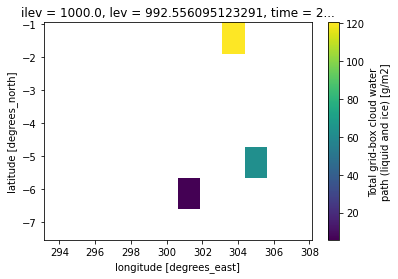

In [40]:
ds_all['TGCLDCWP_incld'].sel(time='2012-05-30 02:00:00').plot()

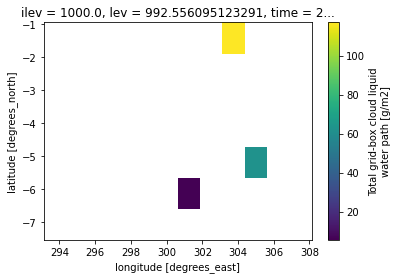

In [41]:
ds_all['TGCLDLWP_incld'].sel(time='2012-05-30 02:00:00').plot()

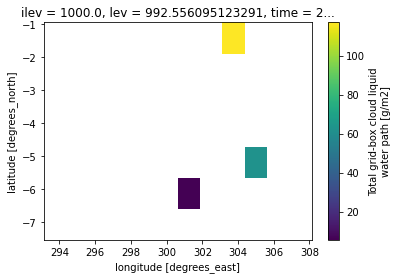

In [42]:
ds_all['TGCLDLWP_incld'].sel(time='2012-05-30 02:00:00').plot()

#### Finally steps

In [43]:
dic_ds = dict()
dic_ds[case_name_noresm] = ds_all

##### Rename vars

In [44]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_noresm_cloud)

#### Save netcdf file

In [45]:
if True:#not :#fn_comb_lev1_finaler.exists():
    with ProgressBar():
        dic_ds[case_name_noresm].to_netcdf(fn_comb_lev1_finaler)

#### Controle plots

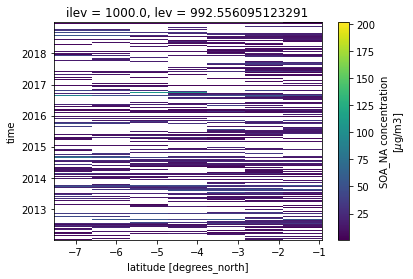

In [46]:
dic_ds[case_name_noresm]['OA'].mean('lon').plot()

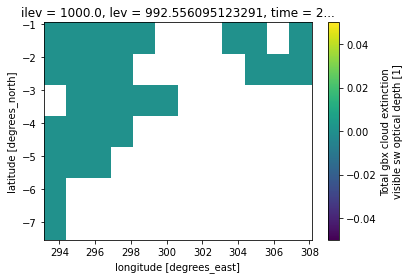

In [47]:
dic_ds[case_name_noresm]['COT'].sel(time='2018-01-07 00:00:00').plot()

(0.0, 400.0)

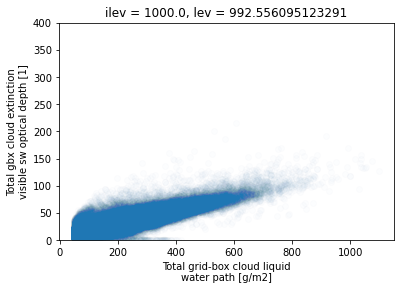

In [48]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']

_ds.where(_ds['COT'] > 0).where(_ds['CWP'] > 50).plot.scatter(x='CWP', y='COT', alpha=0.01)
plt.ylim([0, 400])

(0.0, 400.0)

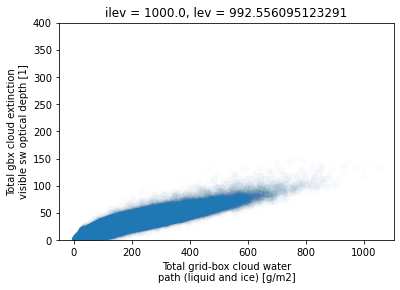

In [49]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']

_ds.where(_ds['COT'] > 0).where(_ds['CWP'] > 50).plot.scatter(x='TGCLDCWP', y='TOT_CLD_VISTAU_s', alpha=0.01)
plt.ylim([0, 400])

#### Save final csv

In [50]:
ds_noresm = ds_all.copy()

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_finalALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 5<COT<50!
Masking with 50<CWP!
Masking with r_eff>1!
cloud and resampled
cloud_avg median
station


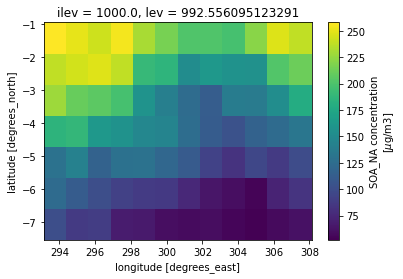

merge
df1
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_finalALL_year.csv
202.83893011277542
DONE! That took 202.83893011277542 seconds
That is  3.3806488352129236 minuts


In [51]:
for seas in calc_seasons:
    _fn_csv = fn_final_csv_stem.parent / (fn_final_csv_stem.stem + seas + '.csv')
    print(_fn_csv)
    if True:# not _fn_csv.exists():
        start = timer()

        dic_df = get_dic_df_mod(
            dic_ds,
            select_hours_clouds=True,
            summer_months=season2month[seas],
            from_hour=daytime_from,
            # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50]),
            kwrgs_mask_clouds=dict(min_reff = r_eff_lim, min_cwp=cld_water_path_above, tau_bounds=tau_lims),

            # kwrgs_mask_clouds = dict(min_reff = 1),
            to_hour=daytime_to,
        )

        df_mod = dic_df[case_name_noresm]

        # df_mod= df_mod.dropna()
        print(_fn_csv)
        df_mod.to_csv(_fn_csv)
        end = timer()
        print(end - start)  # Time in seconds, e.g. 5.38091952400282
        print(f'DONE! That took {(end - start)} seconds')
        print(f'That is  {((end - start) / 60)} minuts')

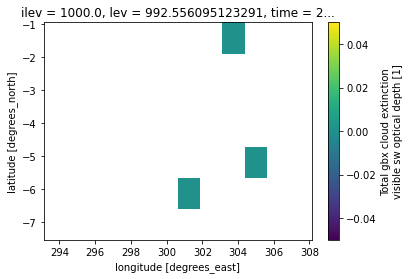

In [52]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time='2012-05-30 02:00:00').plot()

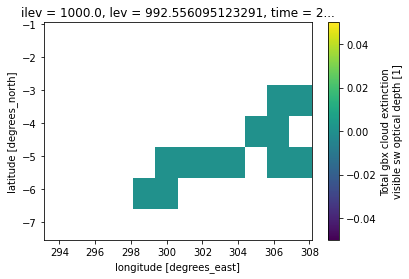

In [53]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time='2012-05-30 23:00:00').plot()

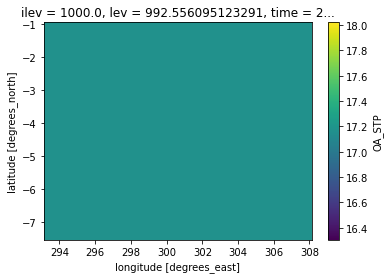

In [54]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['OA_STP'].sel(time='2012-05-30 02:00:00').plot()

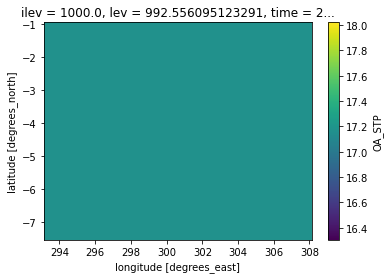

In [55]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['OA_STP'].sel(time='2012-05-30 02:00:00').plot()

### ECHAM-SALSA

#### Names etc

In [56]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res = 'locations'
model_name = 'ECHAM-SALSA'
model_name_echam = 'ECHAM-SALSA'

#### Input path 

In [57]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam

In [58]:

cases_echam = [case_name_echam]

#### Station variables  and others

In [59]:
varl_st_echam = [
    'mmrtrN500',
    'mmrtrN250',
    'mmrtrN200',
    'mmrtrN100',
    'mmrtrN50',
    'mmrtrN3',
    'SO2_gas',
    'APIN_gas',
    'TBETAOCI_gas',
    'BPIN_gas',
    'LIMON_gas',
    'SABIN_gas',
    'MYRC_gas',
    'CARENE3_gas',
    'ISOP_gas',
    'VBS0_gas',
    'V*BS1_gas',
    'VBS10_gas',
    'ORG_mass',
    'oh_con',
    'tempair',
    'ccn02',
    'ccn10',
]

varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    # 'ceff_ct_incl',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
    'tempair',
    'tempair_ct',
    'T_ct',

]



#### Filenames: 

In [60]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_wet_season.csv'
fn_final_echam_csv_stem = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

#### Open data area around station

In [61]:
fl_open = []

for v in varl_cl_echam + varl_st_echam:
    fn = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    # print(fn)
    if fn.exists():
        fl_open.append(fn)
    else:
        print(f'{v} not found')

tempair_ct not found
T_ct not found
mmrtrN500 not found
mmrtrN250 not found
mmrtrN3 not found
SO2_gas not found
APIN_gas not found
TBETAOCI_gas not found
BPIN_gas not found
LIMON_gas not found
SABIN_gas not found
MYRC_gas not found
CARENE3_gas not found
ISOP_gas not found
VBS0_gas not found
V*BS1_gas not found
VBS10_gas not found
oh_con not found


#### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [62]:
fl_open = list(set(fl_open))

In [63]:
ds_all = xr.open_mfdataset(fl_open, decode_cf=False)

In [64]:
if not fn_final_echam.exists():
    ds_all = xr.open_mfdataset(fl_open, decode_cf=False)
    # ds_iso = xr.open_dataset(fl_open[21])
    # ds = xr.merge([ds_iso,ds])
    ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)

    # ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_echam(ds_all)

    # ds_sel = ds_all.sel(lat = lat_station, lon= lon_station, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    ds_all = ds_all.drop(['hyai', 'hybi', 'hyam', 'hybm']).squeeze()
    ds_all = ds_all.isel(lev=model_lev_i)

    # ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam, lon = lon_station, lat = lat_station)

    ds_all = change_units_and_compute_vars_echam(ds_all)

    delayed_obj = ds_all.to_netcdf(fn_final_echam, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()


#### Add variables from station data to imitate using station measurements

In [65]:
df_comb_station = dic_df_station['ECHAM-SALSA']['SALSA_BSOA_feedback']

#### Moved to preprocess: Compute Nx-500

for v in ['N50', 'N100', 'N200', 'N150', 'N25', 'N70', 'N250']:
    if v in df_comb_station.columns:
        df_comb_station[v + '-500'] = df_comb_station[v] - df_comb_station['N500']
        varl_st_computed.append(v + '-500')
        print(v)

In [66]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

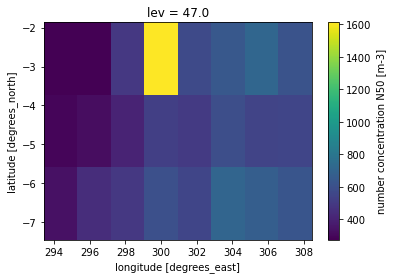

In [67]:
ds_all = xr.open_dataset(fn_final_echam, engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['N50'].mean('time').plot()  # .isel(lat=0, time=0).plot()#.shape#.plot()

In [68]:
ds_all['time'].attrs['timezone'] = 'utc'

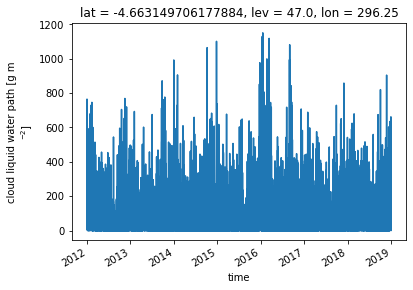

In [69]:
ds_all['cwp_incld'].isel(lat=1, lon=1).plot()

#### Fix time for echam

In [70]:
with xr.set_options(keep_attrs=True):
    attrs = ds_all['time'].attrs.copy()
    ds_all['time'] = ds_all['time'].to_dataframe()['time'].apply(fix_echam_time).values
    ds_all['time'].attrs = attrs

#### Finally produce daily median dataset:

In [71]:
dic_ds = dict()
dic_ds[case_name] = ds_all

##### Controle plots

(array([5.64041e+05, 2.57119e+05, 1.49413e+05, 8.69250e+04, 4.84780e+04,
        2.80940e+04, 1.71860e+04, 1.03990e+04, 6.27000e+03, 3.98900e+03,
        2.55600e+03, 1.73100e+03, 1.17100e+03, 8.24000e+02, 5.63000e+02,
        4.09000e+02, 2.56000e+02, 1.91000e+02, 1.32000e+02]),
 array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
         210.52631579,  263.15789474,  315.78947368,  368.42105263,
         421.05263158,  473.68421053,  526.31578947,  578.94736842,
         631.57894737,  684.21052632,  736.84210526,  789.47368421,
         842.10526316,  894.73684211,  947.36842105, 1000.        ]),
 <BarContainer object of 19 artists>)

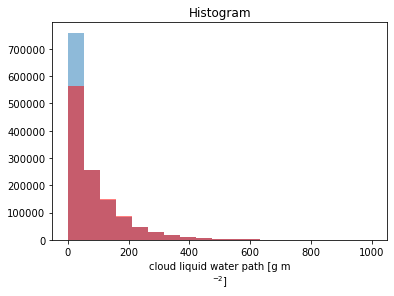

In [72]:
ds_all['cwp'].plot(bins=np.linspace(0, 1000, 20), alpha=.5, )

ds_all['cwp_incld'].plot(bins=np.linspace(0, 1000, 20), alpha=.5, color='r')

In [73]:
ds_all['cwp_incld2'] = ds_all['cwp'] / ds_all['cl_clfr_max']

(array([ 3971.,  4354.,  4583.,  5029.,  5570.,  6060.,  6769.,  7362.,
         7912.,  8854.,  9790., 11199., 12267., 13444., 14884., 16678.,
        18533., 20113., 22241., 24524., 26970., 29554., 32722., 35633.,
        39228., 42320., 45561., 48886., 52411., 54853., 56032., 56727.,
        55760., 53818., 50145., 45799., 38993., 31434., 24875., 18885.,
        13950.,  9238.,  5909.,  3651.,  2188.,  1272.,   632.,   313.,
          103.]),
 array([1.00000000e+00, 1.15681872e+00, 1.33822954e+00, 1.54808898e+00,
        1.79085830e+00, 2.07169840e+00, 2.39657948e+00, 2.77240800e+00,
        3.20717346e+00, 3.71011828e+00, 4.29193426e+00, 4.96498988e+00,
        5.74359321e+00, 6.64429612e+00, 7.68624610e+00, 8.89159334e+00,
        1.02859616e+01, 1.18989929e+01, 1.37649776e+01, 1.59235837e+01,
        1.84206997e+01, 2.13094102e+01, 2.46511245e+01, 2.85168821e+01,
        3.29888630e+01, 3.81621341e+01, 4.41466709e+01, 5.10696951e+01,
        5.90783791e+01, 6.83429746e+01, 7.9060

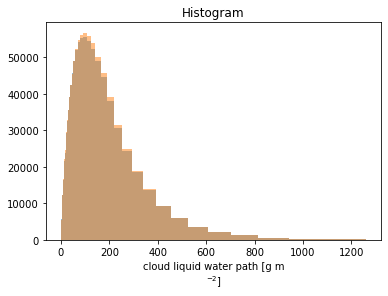

In [74]:
f, ax = plt.subplots(1)
ds_all['cwp'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)

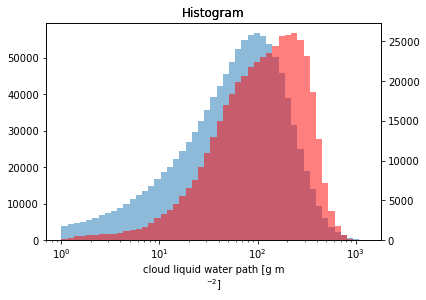

In [75]:
f, ax = plt.subplots(1)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)

ds_noresm['TGCLDCWP_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=0.5, ax=ax.twinx(), color='r')
plt.xscale('log')

#### *Mask values where cloud time max and cloud top cloud time is less than 10 percent 

(array([289475.,  18857.,  19275.,  21686.,      0.,  29491.,  34908.,
         51618.,  54147., 953375.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

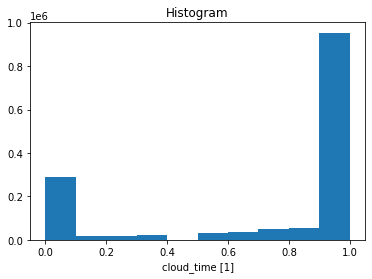

In [76]:
ds_all['cl_time_max'].plot.hist()

(array([ 15323.,  20049.,  22891.,      0.,  28704.,  31401.,      0.,
         41515.,  38483., 551999.]),
 array([0.125 , 0.2125, 0.3   , 0.3875, 0.475 , 0.5625, 0.65  , 0.7375,
        0.825 , 0.9125, 1.    ], dtype=float32),
 <BarContainer object of 10 artists>)

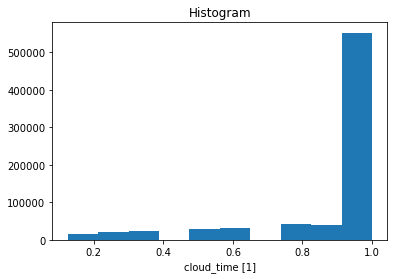

In [77]:
ds_all['cl_time_ct'].where(ds_all['cl_time_max']>.1).plot.hist()

In [78]:
number_before_mask = ds_all['ceff_ct_incld'].count()

In [79]:
ds_all = ds_all.where(ds_all['cl_time_max'] > .1)
ds_all = ds_all.where(ds_all['cl_time_ct'] > .1)

In [80]:
(ds_all['ceff_ct_incld'].count()-number_before_mask)/number_before_mask

<xarray.DataArray 'ceff_ct_incld' ()>
array(0.)
Coordinates:
    lev      float64 47.0
Attributes:
    long_name:    cloud droplet effective radius cloud top
    units:        um
    description:  cloud droplet effective radius cloud top

#### Shift timezone

In [81]:

with ProgressBar():
    ds_all.load()

if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=4)
    ds_all['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    # dic_ds[k] = _ds

shifted time by -4


#### Broadcast computed variables so that only station value is in the gridcells. 

In [82]:
ds_smll = ds_all[['mmrtrN100']]

In [83]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

##### Check time by comparing to station dataset

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


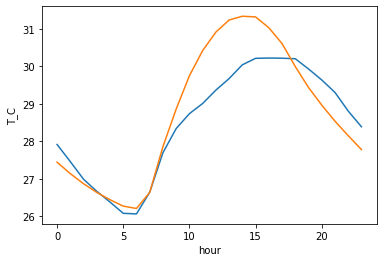

In [84]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_station, lon=lon_station, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


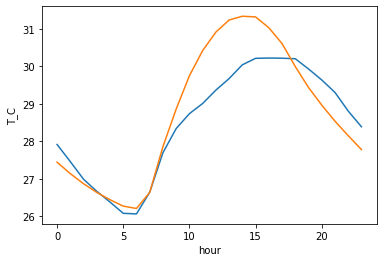

In [85]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_station, lon=lon_station, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

In [86]:
ds_comb_station = ds_comb_station.drop(['lon'])

In [87]:
varl_tmp = varl_st_echam + varl_st_computed

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [88]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

VBS10_gas
replacing VBS10_gas 
SABIN_gas
replacing SABIN_gas 
ISOP_gas
replacing ISOP_gas 
SO2_gas
replacing SO2_gas 
mmrtrN100
replacing mmrtrN100 
mmrtrN3
replacing mmrtrN3 
ccn10
replacing ccn10 
oh_con
replacing oh_con 
T_C
replacing T_C 
TBETAOCI_gas
replacing TBETAOCI_gas 
mmrtrN200
replacing mmrtrN200 
CARENE3_gas
replacing CARENE3_gas 
MYRC_gas
replacing MYRC_gas 
VBS0_gas
replacing VBS0_gas 
mmrtrN50
replacing mmrtrN50 
mmrtrN250
replacing mmrtrN250 
mmrtrN500
replacing mmrtrN500 
OA
replacing OA 
LIMON_gas
replacing LIMON_gas 
ccn02
replacing ccn02 
APIN_gas
replacing APIN_gas 
BPIN_gas
replacing BPIN_gas 
ORG_mass
replacing ORG_mass 


#### Replace all values by station values

In [89]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

(array([    0., 10493.,  6932.,  9970., 15791., 23288., 25859., 24874.,
        23330., 21510., 19756., 17776., 16043., 14279., 13098., 11945.,
        10881.,  9692.,  9102.,  8261.,  7403.,  6785.,  6204.,  5675.,
         5217.,  4713.,  4322.,  3978.,  3691.,  3411.,  3160.,  2976.,
         2804.,  2543.,  2419.,  2183.,  2031.,  1855.,  1783.,  1653.,
         1572.,  1455.,  1366.,  1296.,  1181.,  1108.,   963.,   915.,
          831.,   803.]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <BarContainer object of 50 artists>)

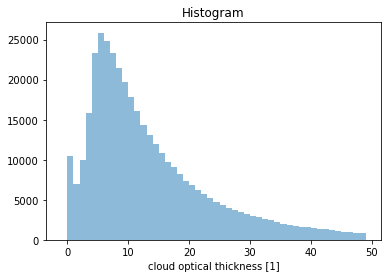

In [90]:
ds_all.where((ds_all['cwp_incld'] > 50) & (ds_all['cl_time_max'] > .1))['cod_incld'].plot.hist(bins=np.arange(-1, 50),
                                                                                               alpha=.5)

#### Final steps

In [91]:
dic_ds = dict()
dic_ds[case_name_echam] = ds_all

##### Rename vars

In [92]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_echam_cloud)

#### Save final csv

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 5<COT<50!
Masking with 50<CWP!
Masking with r_eff>1!
Masking with temp>-15!
cloud and resampled
cloud_avg median
station


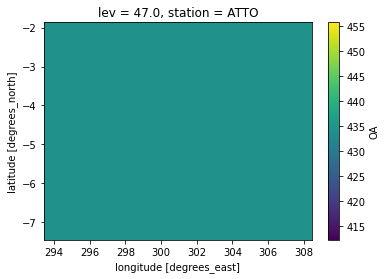

merge
df1


In [93]:
for seas in calc_seasons:
    _fn_csv = fn_final_echam_csv_stem.parent / (fn_final_echam_csv_stem.stem + seas + '.csv')
    print(_fn_csv)
    if True:  # not _fn_csv.exists():
        # for key in dic_ds.keys():

        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month[seas],
                                mask_cloud_values=True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds=dict(min_reff=r_eff_lim, min_cwp=cld_water_path_above,
                                                       tau_bounds=tau_lims),

                                )

        df_mod = dic_df[case_name_echam]
        # with ProgressBar():
        # df_mod = df_mod.dropna()
        df_mod.to_csv(_fn_csv)

<AxesSubplot:xlabel='CWP', ylabel='COT'>

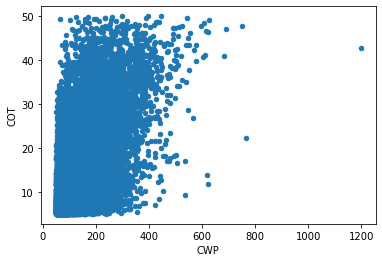

In [94]:
df_mod.plot.scatter(x='CWP', y='COT')

In [95]:
_fn_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

### EC-Earth

#### Names etc

In [96]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res = 'locations'
model_name = 'EC-Earth'
model_name_ec_earth = 'EC-Earth'

#### Input path:

In [97]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth / case_name_ec_earth

In [98]:

cases_ec_earth = [case_name_ec_earth]

#### Filenames: 

In [99]:
fn_intermediate_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate.nc'
fn_intermediate_ec_earth_lev = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate_lev.nc'

fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'
fn_final_ec_earth_csv_stem = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}'

In [100]:
fn_final_ec_earth_csv_stem

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0')

#### Open pre calculated extracted fields

In [101]:
which = 'IFS'

In [102]:
fn_t = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'

In [103]:
fl_open = []
# ds_list =[]
dic_ds = dict()

for which in ['IFS', 'IFS_T']:
    fn = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
    print(fn)
    if fn.exists():
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        dic_ds[which] = _ds
    else:
        print(f'{v} not found')

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_T_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc


#### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [104]:
from bs_fdbck.util.BSOA_datamanip.ec_earth import (
    rename_ifs_vars,
    fix_units_ec_earth,
    extract_cloud_top,
    calculate_incld_values_warmclouds,
)

#### Fix units, calc cloud properties etc.

In [105]:
fn_intermediate_ec_earth

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0_intermediate.nc')

In [106]:
if not fn_intermediate_ec_earth.exists():

    for key in dic_ds:
        _ds = dic_ds[key]
        _ds = rename_ifs_vars(_ds)

        _ds = fix_units_ec_earth(_ds)
        # _ds = calculate_incld_values_warmclouds(_ds)
        # _ds = extract_cloud_top(_ds)
        # _ds['lat'] = np.round(_ds['lat'], decimals=2)
        # _ds['lon'] = np.round(_ds['lon'], decimals=2)
        _ds = _ds.sortby('lon')
        _ds = _ds.sortby('lat')
        _ds = (
            _ds
            .assign(
                lat=lambda d: d['lat'].astype('float').round(2))
            .assign(
                lon=lambda d: d['lon'].astype('float').round(2))
        )

        dic_ds[key] = _ds

    ds = dic_ds['IFS']

    ds = calculate_incld_values_warmclouds(ds)

    ds = extract_cloud_top(ds)

    dic_ds['IFS'] = ds

    for key in dic_ds:
        _ds = dic_ds[key]
        ds_l = _ds.isel(lev=model_lev_i)
        dic_ds[key] = ds_l

    ds_t = dic_ds['IFS_T']

    ds = dic_ds['IFS']
    ds = ds.sortby('lat')
    ds = ds.sortby('lon')

    ds_t['lev'] = ds['lev']
    ds_t = ds_t.sortby('lat')
    ds_t = ds_t.sortby('lon')
    ds_t['temp'].plot()
    plt.show()

    drop_list = ['U', 'V', 'temp']
    ds = xr.merge([ds.drop_vars(drop_list).drop_dims(['plev']), ds_t[['temp']]])
    ds['temp'].plot()
    plt.show()

    # ds =fix_units_ec_earth(ds)
    # ds = calculate_incld_values_warmclouds(ds)
    # ds = extract_cloud_top(ds)

    delayed_obj = ds.to_netcdf(fn_intermediate_ec_earth, compute=False)
    with ProgressBar():
        delayed_obj.compute()

#### Open file with fixed units and extracted cloud params:

In [107]:
ds_ifs = xr.open_dataset(fn_intermediate_ec_earth, decode_times=False)

#### Fix units and decode time

In [108]:
ds_ifs['ttc'].attrs['units'] = 1

for v in ds_ifs.data_vars:
    if 'units' in ds_ifs[v].attrs:
        print(v, ds_ifs[v].attrs['units'])
        if ds_ifs[v].attrs['units'] is np.nan:
            print('******')
        if ds_ifs[v].attrs['units'] == 1:
            ds_ifs[v].attrs['units'] = '1'
            print(f'{v} unit is 1')

ds_ifs = xr.decode_cf(ds_ifs)
ds_ifs['time'].attrs['timezone'] = 'utc'

hyai Pa
hyam Pa
hybi 1
hybm 1
tcw g m-2
tcwv g m-2
ttc 1
ttc unit is 1
surf_net_srad J m-2
surf_net_lrad J m-2
toa_net_srad J m-2
toa_net_lrad J m-2
cdnc cm-3
toa_net_srad_clear J m-2
re_liq  um
surf_net_srad_clear J m-2
sur_net_lrad_clear J m-2
liq_cloud_time sec
cc 1
toa_net_srad_clearclean J m-2
toa_net_srad_clean J m-2
surf_net_srad_clearclean J m-2
surf_net_srad_clean J m-2
toa_net_lrad_clearclean J m-2
toa_net_lrad_clean J m-2
surf_net_lrad_clearclean J m-2
surf_net_lrad_clean J m-2
tclw g m-2
tciw g m-2
re_liq_incld  um
cdnc_incld cm-3
cl_time_liq_norm sec
cc_all 1
liq_frac_cwp g m-2
cl_frac_where_cltime_pos 1
cwp_incld g m-2
cloud_time_norm sec
cumsum 1
argmax 1
cdnc_incld_cltop cm-3
re_liq_cltop  um
cc_cltop 1
temp K


#### Overview plots

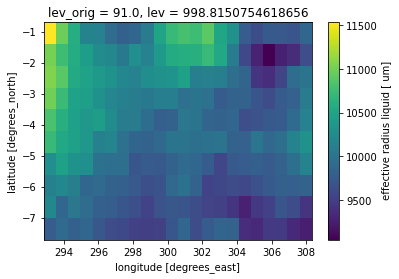

In [109]:
ds_ifs['re_liq_cltop'].count('time').plot()

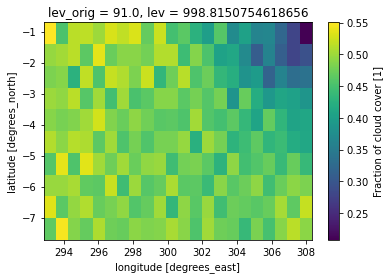

In [110]:
ds_ifs['cl_frac_where_cltime_pos'].mean('time').plot()

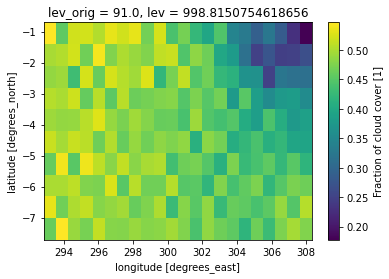

In [111]:
ds_ifs['cc_all'].mean('time').plot()

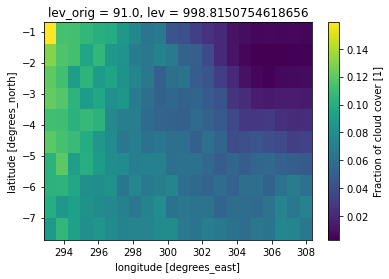

In [112]:
ds_ifs['cc'].mean('time').plot()

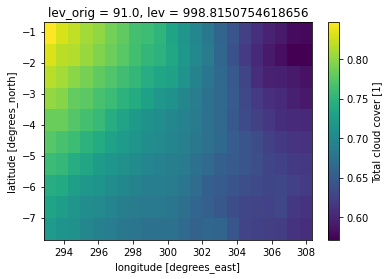

In [113]:
ds_ifs['ttc'].mean('time').plot()

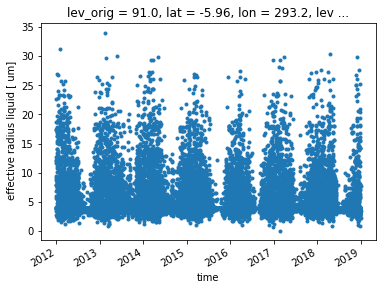

In [114]:
ds_ifs['re_liq'].isel(lat=2, lon=0).plot(x='time', linewidth=0, marker='.')

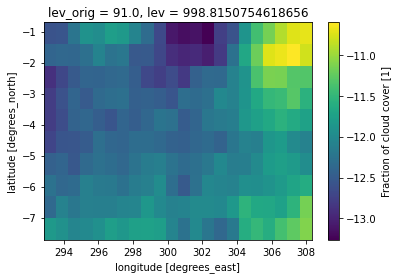

In [115]:
ds_ifs['argmax'].mean('time').plot()

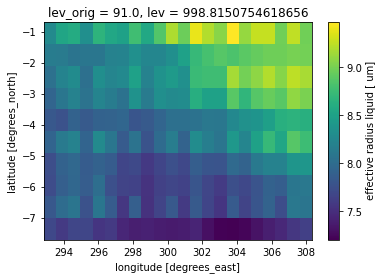

In [116]:
ds_ifs['re_liq_cltop'].mean('time').plot()

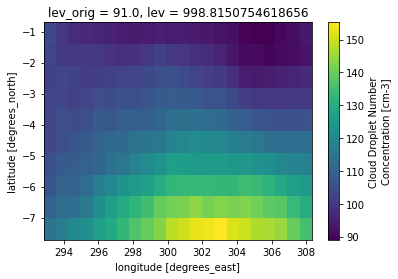

In [117]:
ds_ifs['cdnc_incld_cltop'].mean('time').plot()

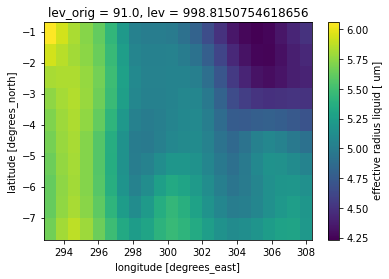

In [118]:
ds_ifs['re_liq'].mean('time').plot()

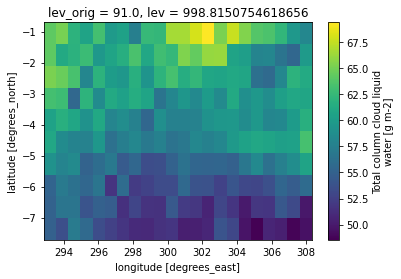

In [119]:
ds_ifs['tclw'].mean('time').plot()

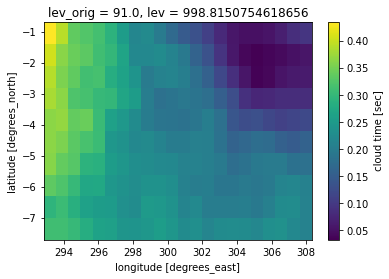

In [120]:
ds_ifs['cloud_time_norm'].mean('time').plot()

#### Masking and computing vars

##### *Mask values where cloud fraction is less than 10 percent

In [121]:
xr.set_options(keep_attrs=True)

(array([777749., 389259., 242567., 157146., 116609., 104515.,  92563.,
         79977.,  68542., 166519.]),
 array([0.203125 , 0.2828125, 0.3625   , 0.4421875, 0.521875 , 0.6015625,
        0.68125  , 0.7609375, 0.840625 , 0.9203125, 1.       ],
       dtype=float32),
 <BarContainer object of 10 artists>)

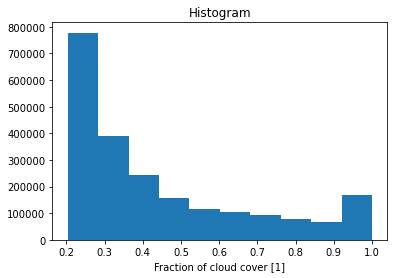

In [122]:
ds_ifs['cc_cltop'].plot.hist()

In [123]:
ds_ifs = ds_ifs.where(ds_ifs['cc_cltop'] > .1)

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,  56141., 144534., 315635.]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
        0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
        0.71428571, 0.734

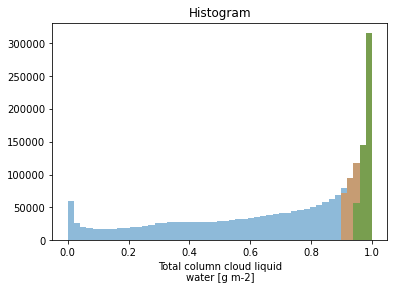

In [124]:
ds_ifs['liq_frac_cwp'].plot(bins=np.linspace(0,1), alpha=.5)
ds_ifs['liq_frac_cwp'].where(ds_ifs['liq_frac_cwp'] > .90).plot(bins=np.linspace(0,1), alpha=.5)
ds_ifs['liq_frac_cwp'].where(ds_ifs['liq_frac_cwp'] > .95).plot(bins=np.linspace(0,1), alpha=.5)

##### *Mask if ice water path more than 5% of total water path

In [125]:
ds_ifs = ds_ifs.where(ds_ifs['liq_frac_cwp'] > .95)

#### Shift timezone

In [126]:

with ProgressBar():
    ds_ifs.load()

if ds_ifs['time'].attrs['timezone'] == 'utc':
    ds_ifs['time'] = ds_ifs['time'].to_pandas().index - timedelta(hours=4)
    ds_ifs['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    # dic_ds[k] = _ds

shifted time by -4


#### Use station data computed before:

In [127]:
df_comb_station = dic_df_station[model_name_ec_earth][case_name_ec_earth]

In [128]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

(array([   205.,  16672.,  80579.,  92973., 113683.,  70476.,  56250.,
         56070.,  27631.,   1771.]),
 array([290.6362 , 293.1899 , 295.74362, 298.2973 , 300.851  , 303.40472,
        305.95844, 308.51215, 311.06583, 313.61954, 316.17325],
       dtype=float32),
 <BarContainer object of 10 artists>)

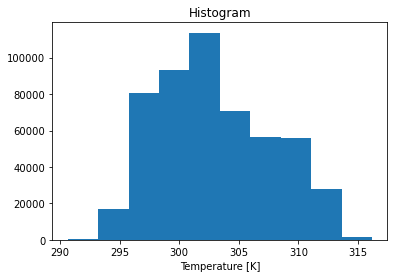

In [129]:
ds_ifs['temp'].plot()

##### Check time against station data

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


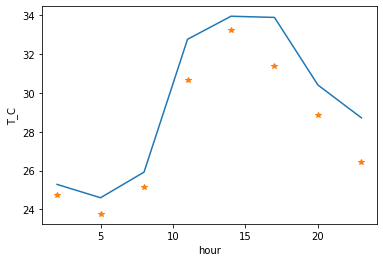

In [130]:
ds_ifs['hour'] = ds_ifs['time.hour']
_ds1 = ds_ifs.sel(time=slice('2012-07', '2012-08'))
_ds2 = ds_comb_station.sel(time=slice('2012-07', '2012-08'))
(_ds1['temp'] - 273.15).groupby(_ds1['hour']).mean().sel(lat=lat_station, lon=lon_station, method='nearest').plot()
_ds2['T_C'].groupby(_ds2['time.hour']).mean().plot(marker='*')

In [131]:
varl_station_ec_earth = [
    'CCN0.20',
    'CCN1.00',
    'M_BCACS',
    'M_BCAII',
    'M_BCAIS',
    'M_BCCOS',
    'M_DUACI',
    'M_DUACS',
    'M_DUCOI',
    'M_DUCOS',
    'M_POMACS',
    'M_POMAII',
    'M_POMAIS',
    'M_POMCOS',
    'M_SO4ACS',
    'M_SO4COS',
    'M_SO4NUS',
    'M_SOAACS',
    'M_SOAAII',
    'M_SOAAIS',
    'M_SOACOS',
    'M_SOANUS',
    'M_SSACS',
    'M_SSCOS',
    'OA',
    'SOA',
    'N_ACI',
    'N_ACS',
    'N_AII',
    'N_AIS',
    'N_COI',
    'N_COS',
    'N_NUS',
    'RDRY_ACS',
    'RDRY_AIS',
    'RDRY_COS',
    'RDRY_NUS',
    'RWET_ACI',
    'RWET_ACS',
    'RWET_AII',
    'RWET_AIS',
    'RWET_COI',
    'RWET_COS',
    'RWET_NUS',
    'emiisop',
    'emiterp',
    'T',
    'DDRY_NUS',
    'DDRY_AIS',
    'DDRY_ACS',
    'DDRY_COS',
    'DWET_AII',
    'DWET_ACI',
    'DWET_COI',
    'N50',
    'N70',
    'N100',
    'N150',
    'N200',
    'N500',
    'N50-500',
    'N70-500',
    'N100-500',
    'N150-500',
    'N200-500',
    'N50-500_STP',
    'N100-500_STP',
    'N200-500_STP',
    'N50_STP',
    'N100_STP',
    'N200_STP',
    'OA_STP',
    'POM',
    'SOA',
    'SOA2',
    'T_C',

]

In [132]:

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_station_ec_earth)))

In [133]:
ds_smll = ds_ifs[['temp']]

In [134]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

POM
replacing POM 
M_POMCOS
replacing M_POMCOS 
RWET_ACS
replacing RWET_ACS 
M_BCAIS
replacing M_BCAIS 
M_SO4COS
replacing M_SO4COS 
RDRY_AIS
replacing RDRY_AIS 
RWET_COI
replacing RWET_COI 
N200_STP
replacing N200_STP 
RWET_COS
replacing RWET_COS 
SOA
replacing SOA 
RWET_AIS
replacing RWET_AIS 
DDRY_ACS
replacing DDRY_ACS 
DWET_ACI
replacing DWET_ACI 
DWET_COI
replacing DWET_COI 
M_BCACS
replacing M_BCACS 
OA_STP
replacing OA_STP 
DDRY_NUS
replacing DDRY_NUS 
N100_STP
replacing N100_STP 
RWET_AII
replacing RWET_AII 
emiterp
replacing emiterp 
M_SOACOS
replacing M_SOACOS 
N_NUS
replacing N_NUS 
N_AIS
replacing N_AIS 
M_POMACS
replacing M_POMACS 
N50-500
replacing N50-500 
N_COI
replacing N_COI 
RDRY_ACS
replacing RDRY_ACS 
RWET_ACI
replacing RWET_ACI 
T
replacing T 
DWET_AII
replacing DWET_AII 
DDRY_AIS
replacing DDRY_AIS 
N_ACS
replacing N_ACS 
N_COS
replacing N_COS 
M_SOANUS
replacing M_SOANUS 
N100-500
replacing N100-500 
M_SOAAIS
replacing M_SOAAIS 
N100-500_STP
replacing N100-500_

##### Replace all values by station values

In [135]:
for v in varl_tmp:
    ds_ifs[v] = ds_smll[v]

#### Final adjustments


In [136]:
dic_ds = dict()
dic_ds[case_name_ec_earth] = ds_ifs

##### Rename variables

In [137]:
# calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ec_earth_cloud)

In [138]:
ds = dic_ds[key]

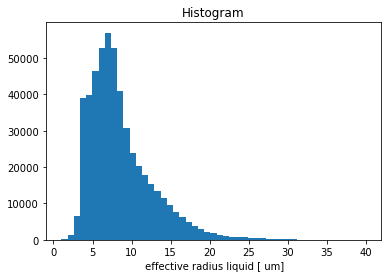

In [139]:
ds['r_eff'].plot(bins=np.linspace(1, 40));

In [140]:
ds['CWP_unweigth'] = ds['tclw']

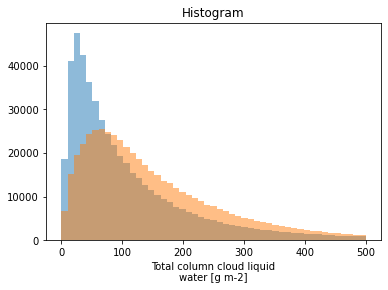

In [141]:
ds['CWP_unweigth'].plot(bins=np.linspace(0, 500), alpha=.5);
ds['CWP'].plot(bins=np.linspace(0, 500), alpha=.5);

##### Controle plots normalizing by cloud fraction

Text(0.5, 1.0, 'CWP divided by cloud fraction')

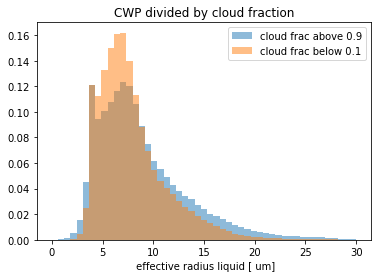

In [142]:
ds['r_eff'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc'] < .4).plot(bins=np.linspace(0, 30), alpha=.5, density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP divided by cloud fraction')

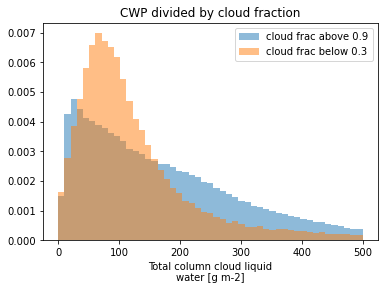

In [143]:
ds['CWP'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP'].where(ds['ttc'] < .3).plot(bins=np.linspace(0, 500), alpha=.5, density=True, label='cloud frac below 0.3');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP not divided ')

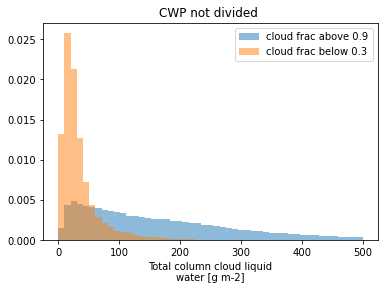

In [144]:
ds['CWP_unweigth'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 500), alpha=.5, density=True,
                                              label='cloud frac above 0.9');
ds['CWP_unweigth'].where(ds['ttc'] < .3).plot(bins=np.linspace(0, 500), alpha=.5, density=True,
                                              label='cloud frac below 0.3');
plt.legend()
plt.title('CWP not divided ')

#### Final save csv

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 50<CWP!
Masking with r_eff>1!
cloud and resampled
cloud_avg median
station


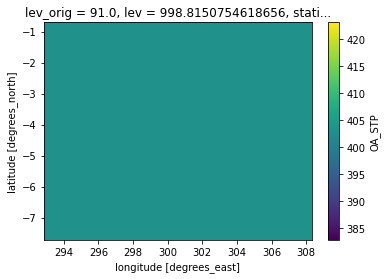

merge
df1


In [145]:
for seas in calc_seasons:
    _fn_csv = fn_final_ec_earth_csv_stem.parent / (fn_final_ec_earth_csv_stem.name + seas + '.csv')
    print(_fn_csv)

    if True:  # not _fn_csv.exists():
        # for key in dic_ds.keys():

        dic_df = get_dic_df_mod(dic_ds,
                                select_hours_clouds=True,
                                summer_months=season2month[seas],
                                mask_cloud_values=True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds=dict(min_reff=r_eff_lim,
                                                       min_cwp=cld_water_path_above,
                                                       tau_bounds=tau_lims
                                                       ),

                                )

        df_mod = dic_df[case_name_ec_earth]
        # with ProgressBar():
        # df_mod = df_mod.dropna()
        df_mod.to_csv(_fn_csv)

<AxesSubplot:ylabel='Frequency'>

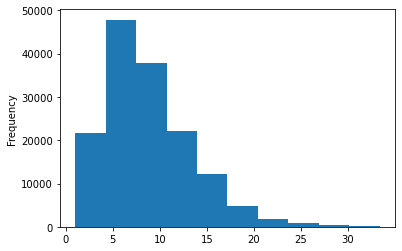

In [146]:
df_mod['r_eff'].plot.hist()

In [147]:
print('Done')

Done
